In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
df_train=pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test=pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
def transform(df):
    
    avg_age=round(df_train.Age.mean(),2)
    df['Age'].fillna(avg_age,inplace=True)
    
    df=df.drop(['Name','Ticket','Cabin','Embarked'],axis=1)
    le=LabelEncoder()    
    df['Sex']=le.fit_transform(df['Sex'])
    
    return df

In [8]:
df_train = transform(df_train)
df_test = transform(df_test)

In [9]:
X=df_train.drop('Survived',axis=1)
y=df_train.Survived

In [10]:
model_params = {
    'rf':{
        'model': RandomForestClassifier(),
        'params':{
            'n_estimators':[5,10,20,50], 
            'max_depth':[3,5,7,10],
            'min_samples_split':[2,3,5,7],
            'min_samples_leaf':[3,5,7,10]
        }
    },
    'dt':{
        'model': DecisionTreeClassifier(),
        'params':{
            'max_depth':[2,3,5,10],
            'min_samples_split':[2,3,5,7],
            'min_samples_leaf':[3,5,7,10]
        }        
    },
    'xg':{
        'model': XGBClassifier(),
        'params':{
            'max_depth':[5,7,10],
            'learning_rate':[0.01, 0.1,0.2],
            'n_estimators':[5,10,20]
        }
    }
}

In [11]:
# GridSearchCV
scores=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],cv=10,return_train_score=False)
    clf.fit(X,y)
    scores.append({'model': model_name,'best_score':clf.best_score_,'best_params':clf.best_params_})
    
gs_df=pd.DataFrame(scores,columns=['model','best_score','best_params'])
gs_df

,model,best_score,best_params
0,rf,0.839551,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s..."
1,dt,0.817054,"{'max_depth': 3, 'min_samples_leaf': 3, 'min_s..."
2,xg,0.820487,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."


In [12]:
gs_df['best_params'][0]

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 20}

In [13]:
#RandomizedSearchCV
scores=[]
for model_name,mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'],mp['params'],cv=10,return_train_score=False,n_iter=5)
    clf.fit(X,y)
    scores.append({'model': model_name,'best_score':clf.best_score_,'best_params':clf.best_params_})
    
rs_df=pd.DataFrame(scores,columns=['model','best_score','best_params'])
rs_df

,model,best_score,best_params
0,rf,0.820474,"{'n_estimators': 10, 'min_samples_split': 5, '..."
1,dt,0.817054,"{'min_samples_split': 5, 'min_samples_leaf': 1..."
2,xg,0.815993,"{'n_estimators': 5, 'max_depth': 10, 'learning..."


In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=47)

In [16]:
model_rc = RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=2,n_estimators=20)
model_rc.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=20)

In [17]:
y_pred=model_rc.predict(X_test)
accuracy_score(y_test,y_pred)

0.8379888268156425

<Axes: >

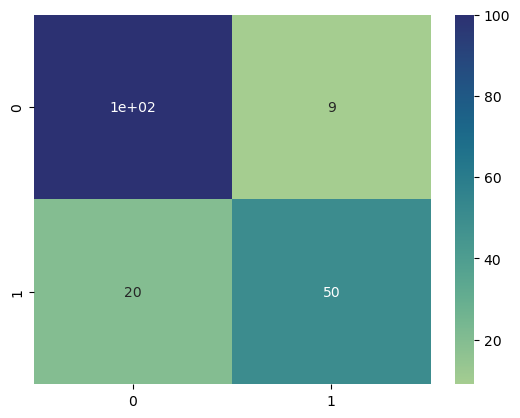

In [18]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,cmap='crest')

In [19]:
kaggle_test=model_rc.predict(df_test)
kaggle_test

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [23]:
#Submission
pred=pd.DataFrame(kaggle_test)
sub_df=pd.read_csv('gender_submission.csv')
datasets=pd.concat([sub_df['PassengerId'],pred],axis=1)
datasets.columns=['PassengerId','Survived']
datasets.to_csv('kaggle_submission.csv',index=False)

In [28]:
datasets

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
